# FBS with Coupling DOF Errors
This notebook shows an example of how errors in the response/force locations, compared to the actual coupling locations, can lead to significant errors in the FBS coupled FRFs. This example uses the [beam model](generate_beam_example_system). As a reminder, the individual beam components and coupled beam system (in the correct configuration) are shown below, where beam one is the blue beam and beam two is the red beam. 

![Beam1](./Images/beam1.svg)

![Beam2](./Images/beam2.svg)

Beams one and two are overlapped by 10 cm and are coupled to one another at three (evenly spaced) points at each end of the beam, as shown as the green dots in the image below. 

![CoupledBeams](./Images/CoupledBeams.svg)

## Importing Information for the Example
This section imports the necessary packages and data for the beam example systems. The truth FRFs are imported as a SDynPy `TransferFunctionArray` and are called `beam1_frfs`, `beam2_frfs`, and `coupled_system_frfs`. 

In [1]:
import sdynpy as sdpy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
beam1_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/beam1_frfs.npz')
beam2_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/beam2_frfs.npz')
coupled_system_frfs = sdpy.TransferFunctionArray.load(r'./example_frfs/coupled_beam_system_frfs.npz')

## Coupling DOFs for the Example vs. the Truth Coupling DOFs
The coupling DOFs for this example are listed in the `beam1_incorrect_coupling_coordinate` and `beam2_incorrect_coupling_coordinate` as SDynPy `CoordinateArrays`. The correct coupling DOFs are also shown here in the `beam1_coupling_coordinate` and `beam2_coupling_coordinate` `CoordinateArrays`. As a reminder, the beam total length in 0.5 m and the [model was set-up](sec:beam_generation) so the nodes are spaced 2.5 mm apart from one another. 

A comparison of the correct and incorrect coupling DOFs shows that the the maximum positional error for the incorrect coupling DOFs is 5 mm. This positional error is approximately half the diameter of a standard impact hammer tip (like what is used on a PCB 086C02 hammer) and is likely within the normal errors for a common modal test. Additional positional errors should be expected if measurements are being made around a bolted joint, in lieu of measurements at the actual substructure interface location. 

In [3]:
beam1_coupling_coordinate = sdpy.coordinate_array(node=[1161, 1181, 1201], direction=[3,5], 
                                                  force_broadcast=True)
beam1_incorrect_coupling_coordinate = sdpy.coordinate_array(node=[1160, 1183, 1200], 
                                                            direction=[3,5], force_broadcast=True)

In [4]:
beam2_coupling_coordinate = sdpy.coordinate_array(node=[2001, 2021, 2041], direction=[3,5], 
                                                  force_broadcast=True)
beam2_incorrect_coupling_coordinate = sdpy.coordinate_array(node=[2002, 2020, 2043], 
                                                            direction=[3,5], force_broadcast=True)

## FBS Coupling
This section performs the FBS coupling with the incorrect coupling DOFs (as described above) and shows the resulting errors by comparing the CMIFs for the truth and FBS coupled FRFs (at the "evaluation coordinate"). The CMIF comparisons show that the FBS coupling with the incorrect DOFs adds stiffness to the system, as evidenced by the resonances for the FBS coupled FRFs being higher than the truth FRFs. A 1-3% increase in natural frequency is typical in the plot that is shown below, but some low frequency modes show much greater error.

In [5]:
beam1_evaluation_coordinate = sdpy.coordinate_array(node=[1001, 1051, 1101, 1151], 
                                                    direction=3)
beam2_evaluation_coordinate = sdpy.coordinate_array(node=[2051, 2101, 2151, 2201], 
                                                    direction=3)

In [6]:
coupling_coordinate_pairs = np.column_stack((beam1_incorrect_coupling_coordinate, 
                                             beam2_incorrect_coupling_coordinate))

bd_frfs = sdpy.TransferFunctionArray.block_diagonal_frf((beam1_frfs, beam2_frfs))
fbs_coupled_frfs = bd_frfs.substructure_by_coordinate(coupling_coordinate_pairs)

In [7]:
comparison_coordinate = np.concatenate((beam1_evaluation_coordinate, 
                                        beam2_evaluation_coordinate))
comparison_coordinate = sdpy.coordinate.outer_product(comparison_coordinate, 
                                                      comparison_coordinate)

truth_coupled_cmif = coupled_system_frfs[comparison_coordinate].compute_cmif()
fbs_coupled_cmif = fbs_coupled_frfs[comparison_coordinate].compute_cmif()

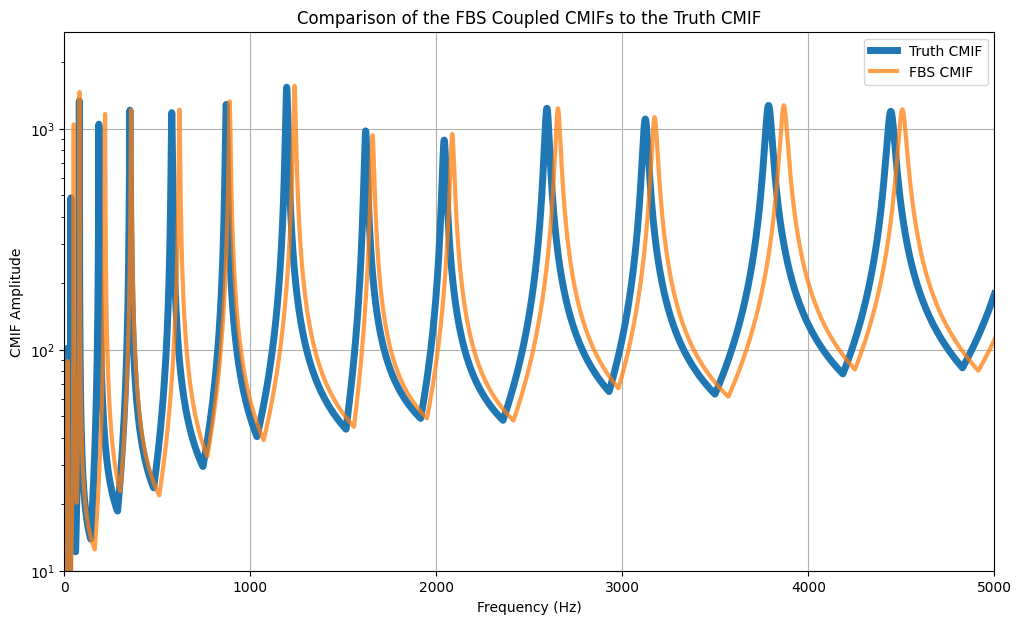

In [8]:
plt.figure(figsize=(12,7))
plt.semilogy(truth_coupled_cmif[0].abscissa, truth_coupled_cmif[0].ordinate, linewidth=5, 
             label='Truth CMIF')
plt.semilogy(fbs_coupled_cmif[0].abscissa, fbs_coupled_cmif[0].ordinate, linewidth=3, 
             alpha=0.75, label='FBS CMIF')
plt.xlim(left=0, right=5000)
plt.ylim(bottom=1e1)
plt.grid()
plt.legend()
plt.title('Comparison of the FBS Coupled CMIFs to the Truth CMIF')
plt.xlabel('Frequency (Hz)')
plt.ylabel('CMIF Amplitude');

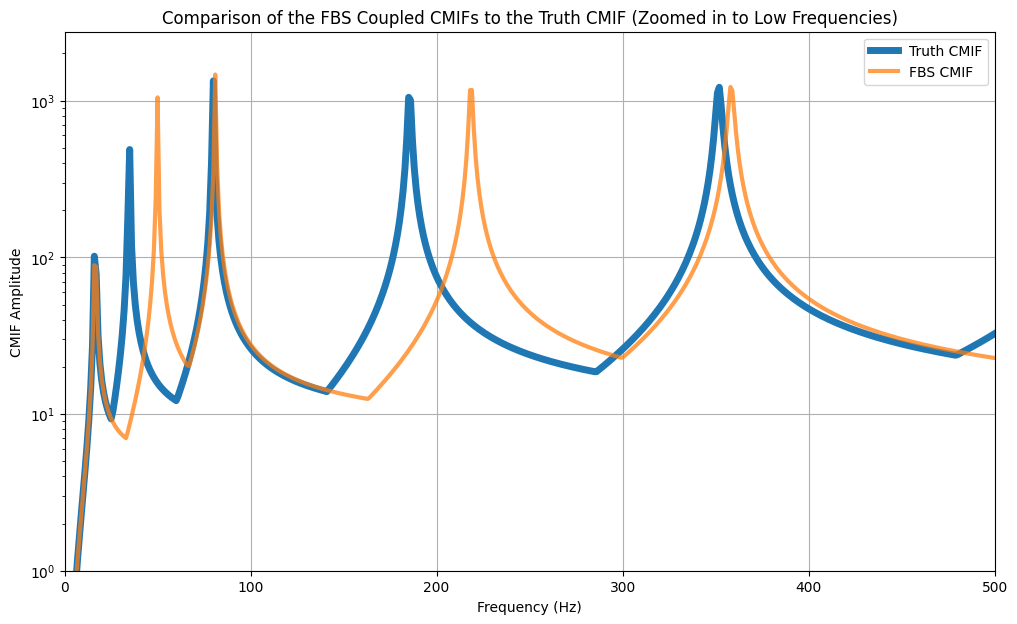

In [10]:
plt.figure(figsize=(12,7))
plt.semilogy(truth_coupled_cmif[0].abscissa, truth_coupled_cmif[0].ordinate, linewidth=5, 
             label='Truth CMIF')
plt.semilogy(fbs_coupled_cmif[0].abscissa, fbs_coupled_cmif[0].ordinate, linewidth=3, 
             alpha=0.75, label='FBS CMIF')
plt.xlim(left=0, right=500)
plt.ylim(bottom=1e0)
plt.grid()
plt.legend()
plt.title('Comparison of the FBS Coupled CMIFs to the Truth CMIF (Zoomed in to Low Frequencies)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('CMIF Amplitude');

## Conclusions
This notebook demonstrated how positional errors in the coupling DOFs can lead to errors in the FBS coupled FRFs. Although the errors weren't significant for all the resonant frequencies in this example, it is important to recognize how positional errors in the coupling DOFs increase the uncertainties in the FBS coupled FRFs. 